In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.font_manager import FontProperties

In [2]:
DATA_PATH="./Vowel_Data/Formant/"

In [3]:
seed=42

In [11]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
            length=len(individual_formant)
            F_i=individual_formant.loc[2:,'F1':'F5'].values
            F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
            F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
            assert len(F_i)==len(F_i1)==len(F_i2)
            #individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=F_i-2*F_i1+F_i2
            
            #individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        #folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        #folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        #folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        #folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['time','label'],axis=1)
    
    standard_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=standard_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

prop=FontProperties()
prop.set_file('/home/rakibul/STUDY/Software/Windows/Fonts/Kalpurush.ttf')

def plot_cnf_mat(cm,classes,title,normalize=True): #Normalization can be avoided by setting normalize=False
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    plt.figure(figsize=(10,9))
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title(title,fontsize=20)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontproperties=prop,fontsize=24)
    plt.yticks(tick_marks,classes,fontproperties=prop,fontsize=24)
    
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black",fontsize=18)
    
    plt.xlabel('Predicted label',fontsize=20)
    plt.ylabel('True label',fontsize=20)
    plt.tight_layout()
    plt.savefig('./New_without_CNN/'+'5F_'+title+'.pdf',format='pdf', dpi=600)

In [5]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)

model_v=Sequential()
model_v.add(Dense(128, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(128, activation='tanh'))
model_v.add(Dense(64, activation='tanh'))
model_v.add(Dense(32, activation='tanh'))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

model_v.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v.fit(X_train, y_train_hot, epochs=300, batch_size=X_train.shape[0])
#y_pred=model_v.predict_classes(X_test) #deprecated
y_pred=np.argmax(model_v.predict(X_test), axis=-1)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 197.38it/s]


Epoch 1/300
1/1 [==============================] - 0s 1ms/step - loss: 1.9674 - accuracy: 0.1633
Epoch 2/300
1/1 [==============================] - 0s 1ms/step - loss: 1.7029 - accuracy: 0.3937
Epoch 3/300
1/1 [==============================] - 0s 1ms/step - loss: 1.5006 - accuracy: 0.4364
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 1.4752 - accuracy: 0.4372
Epoch 5/300
1/1 [==============================] - 0s 2ms/step - loss: 1.4355 - accuracy: 0.4461
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3897 - accuracy: 0.4476
Epoch 7/300
1/1 [==============================] - 0s 3ms/step - loss: 1.3536 - accuracy: 0.4589
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3239 - accuracy: 0.4861
Epoch 9/300
1/1 [==============================] - 0s 1ms/step - loss: 1.2953 - accuracy: 0.5017
Epoch 10/300
1/1 [==============================] - 0s 4ms/step - loss: 1.2688 - accuracy: 0.5094
Epoch 11/300
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.3918 - accuracy: 0.8669
Epoch 168/300
1/1 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.8660
Epoch 169/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3889 - accuracy: 0.8673
Epoch 170/300
1/1 [==============================] - 0s 2ms/step - loss: 0.3876 - accuracy: 0.8670
Epoch 171/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3863 - accuracy: 0.8675
Epoch 172/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3843 - accuracy: 0.8681
Epoch 173/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3811 - accuracy: 0.8694
Epoch 174/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3777 - accuracy: 0.8703
Epoch 175/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3751 - accuracy: 0.8712
Epoch 176/300
1/1 [==============================] - 0s 1ms/step - loss: 0.3736 - accuracy: 0.8716
Epoch 177/300
1/1 [=====

Normalized confusion matrix
[[0.92 0.04 0.   0.01 0.   0.01 0.02]
 [0.02 0.97 0.   0.   0.   0.   0.  ]
 [0.   0.   0.91 0.   0.07 0.   0.02]
 [0.02 0.   0.   0.91 0.01 0.01 0.05]
 [0.   0.   0.06 0.   0.84 0.04 0.06]
 [0.   0.   0.01 0.   0.03 0.95 0.02]
 [0.02 0.01 0.03 0.01 0.1  0.04 0.79]]


<Figure size 432x288 with 0 Axes>

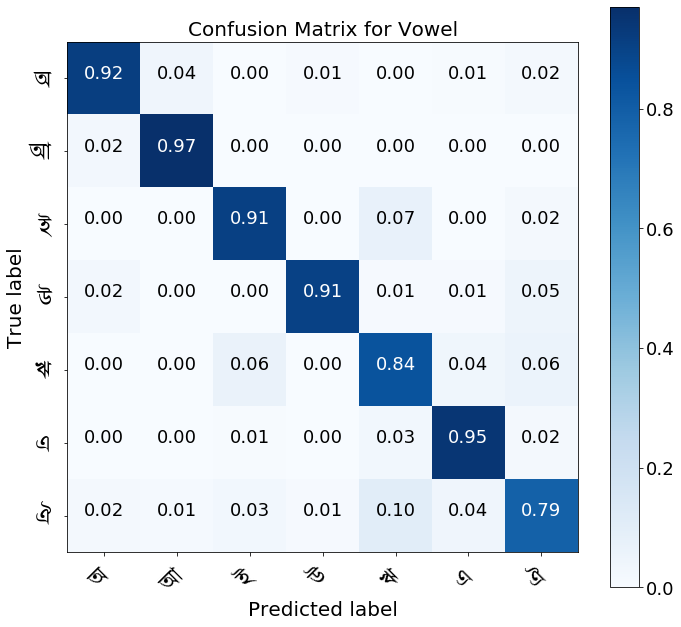

In [12]:
class_names=['অ ','আ ','ই ','উ ','ঋ ','এ ','ঐ ']
cnf_matrix=confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_cnf_mat(cnf_matrix,classes=class_names,title='Confusion Matrix for Vowel')
plt.show()

In [17]:
cnf_matrix

array([[431,  45,  43,  49,  18,  18,  20],
       [ 45, 349,  31,  51,   2,  29,  33],
       [ 37,  38, 299,  32,  18,  57,  24],
       [ 92,  54,  36, 397,  13,  27,  41],
       [  8,   4,  19,   9, 523,  59,  18],
       [ 31,  24,  49,  69,  71, 255,  30],
       [ 68,  44,  33,  40,  24,  31, 200]])

In [19]:
normalized_cnf=cnf_matrix.astype('float')/cnf_matrix.sum(axis=1)[:,np.newaxis]

In [21]:
individual_acc=np.diagonal(normalized_cnf)

In [22]:
individual_acc

array([0.69, 0.65, 0.59, 0.6 , 0.82, 0.48, 0.45])

In [13]:
DATA_PATH="./Word_Data/Formant/"

In [14]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
            length=len(individual_formant)
            F_i=individual_formant.loc[2:,'F1':'F5'].values
            F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
            F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
            assert len(F_i)==len(F_i1)==len(F_i2)
            #individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=F_i-2*F_i1+F_i2
            
            #individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        #folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        #folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        #folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        #folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['time','label'],axis=1)
    
    standard_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=standard_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

prop=FontProperties()
prop.set_file('/home/rakibul/STUDY/Software/Windows/Fonts/Kalpurush.ttf')

def plot_cnf_mat(cm,classes,title,normalize=True): #Normalization can be avoided by setting normalize=False
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    plt.figure(figsize=(10,9))
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title(title,fontsize=20)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontproperties=prop,fontsize=24)
    plt.yticks(tick_marks,classes,fontproperties=prop,fontsize=24)
    
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black",fontsize=18)
    
    plt.xlabel('Predicted label',fontsize=20)
    plt.ylabel('True label',fontsize=20)
    plt.tight_layout()
    plt.savefig('./New_without_CNN/'+'5F_'+title+'.pdf',format='pdf', dpi=600)

In [15]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)

model_w=Sequential()
model_w.add(Dense(128, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(128, activation='tanh'))
model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh'))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_w.fit(X_train, y_train_hot, epochs=300, batch_size=X_train.shape[0])
#y_pred=model_w.predict_classes(X_test)
y_pred=np.argmax(model_w.predict(X_test), axis=-1)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 220.48it/s]


Epoch 1/300
1/1 [==============================] - 0s 1ms/step - loss: 1.9358 - accuracy: 0.1528
Epoch 2/300
1/1 [==============================] - 0s 3ms/step - loss: 1.9026 - accuracy: 0.2771
Epoch 3/300
1/1 [==============================] - 0s 2ms/step - loss: 1.7770 - accuracy: 0.3280
Epoch 4/300
1/1 [==============================] - 0s 1ms/step - loss: 1.7516 - accuracy: 0.3203
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 1.7013 - accuracy: 0.3294
Epoch 6/300
1/1 [==============================] - 0s 1ms/step - loss: 1.6813 - accuracy: 0.3318
Epoch 7/300
1/1 [==============================] - 0s 2ms/step - loss: 1.6756 - accuracy: 0.3310
Epoch 8/300
1/1 [==============================] - 0s 1ms/step - loss: 1.6639 - accuracy: 0.3302
Epoch 9/300
1/1 [==============================] - 0s 1ms/step - loss: 1.6493 - accuracy: 0.3355
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 1.6392 - accuracy: 0.3467
Epoch 11/300
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.9940 - accuracy: 0.6350
Epoch 168/300
1/1 [==============================] - 0s 1ms/step - loss: 0.9914 - accuracy: 0.6362
Epoch 169/300
1/1 [==============================] - 0s 2ms/step - loss: 0.9913 - accuracy: 0.6369
Epoch 170/300
1/1 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.6381
Epoch 171/300
1/1 [==============================] - 0s 1ms/step - loss: 0.9844 - accuracy: 0.6400
Epoch 172/300
1/1 [==============================] - 0s 1ms/step - loss: 0.9823 - accuracy: 0.6428
Epoch 173/300
1/1 [==============================] - 0s 1ms/step - loss: 0.9804 - accuracy: 0.6408
Epoch 174/300
1/1 [==============================] - 0s 5ms/step - loss: 0.9769 - accuracy: 0.6451
Epoch 175/300
1/1 [==============================] - 0s 2ms/step - loss: 0.9745 - accuracy: 0.6458
Epoch 176/300
1/1 [==============================] - 0s 1ms/step - loss: 0.9731 - accuracy: 0.6440
Epoch 177/300
1/1 [=====

Normalized confusion matrix
[[0.69 0.07 0.07 0.08 0.03 0.03 0.03]
 [0.08 0.65 0.06 0.09 0.   0.05 0.06]
 [0.07 0.08 0.59 0.06 0.04 0.11 0.05]
 [0.14 0.08 0.05 0.6  0.02 0.04 0.06]
 [0.01 0.01 0.03 0.01 0.82 0.09 0.03]
 [0.06 0.05 0.09 0.13 0.13 0.48 0.06]
 [0.15 0.1  0.07 0.09 0.05 0.07 0.45]]


<Figure size 432x288 with 0 Axes>

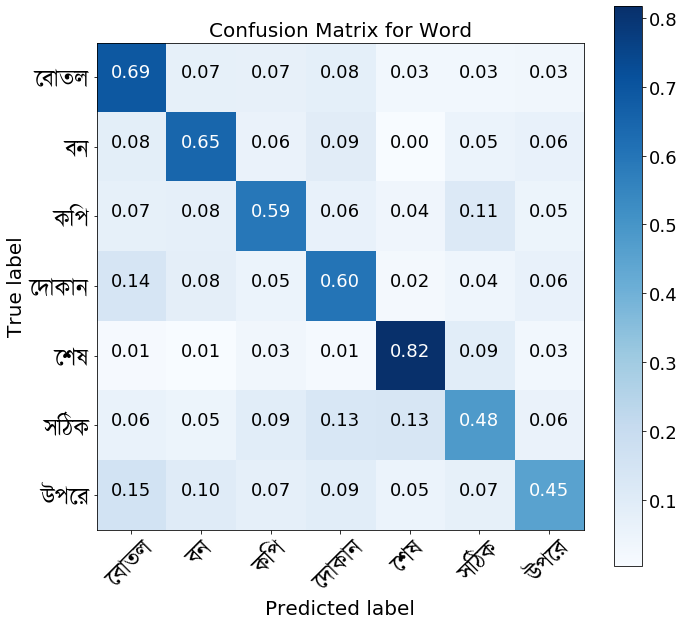

In [16]:
class_names=['েবাতল','বন','কিপ','েদাকান','েশষ','সিঠক','উপের']
cnf_matrix=confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_cnf_mat(cnf_matrix,classes=class_names,title='Confusion Matrix for Word')
plt.show()